## Jupyter Notebook to read in grib2 files from /weather directory and plot cross sections
#### Originally coded by Patrick Beaty for AOS 311
#### pbeaty@wisc.edu

### __Important notes:__
In order to successfully run this notebook, the Python environment must have specific packages downloaded. The environment called 'pbeaty' has these downloaded and should have no errors running this notebook.

Packages needed:
- xarray, os, matplotlib, numpy, glob, cftime, cfgrib, eccodes, wrf, scipy, cartopy, siphon, metpy, pandas

In [2]:
import datetime
today = datetime.datetime.now()
print("Notebook last updated:", today.ctime())

#Import statements
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import cftime
from scipy.interpolate import griddata
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.feature import NaturalEarthFeature
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from scipy.ndimage.filters import gaussian_filter
from wrf import getvar, to_np
from metpy.plots import add_metpy_logo, SkewT, Hodograph
import metpy.calc as mpcalc
from metpy.units import units
from metpy.future import storm_relative_helicity
import matplotlib.gridspec as gridspec
from metpy.interpolate import cross_section
%matplotlib inline
%config InlineBackend.figure_format='retina'

Notebook last updated: Thu May  6 15:28:59 2021


In [4]:
#Ask user if they want the most current model run or a mode run from some other time
file_time = str(input('For most current model run, type 1. Otherwise, type 2.\nYour selection:'))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if file_time == '1':
    model_run = str(input('Which model forecast hour (F???) do you want? For example, hour 36 would be inputted as 036.\nYour selection:'))

For most current model run, type 1. Otherwise, type 2.
Your selection: 1
Which model forecast hour (F???) do you want? For example, hour 36 would be inputted as 036.
Your selection: 012


In [5]:
#Based on above kernel, define filetype with syntax of /weather/data/grib2 syntax
if file_time == '1':
    #Grab most current model run
    startTime=datetime.datetime.now()
    year = startTime.year
    if startTime.month <10:
        month = '0'+str(startTime.month)
    else:
        month = str(startTime.month)
    if startTime.day <10:
        day = '0'+str(startTime.day)
    else:
        day = str(startTime.day)
    if startTime.hour <10:
        hour = '0'+str(startTime.hour)
    else:
        hour = str(startTime.hour)
    mdate = str(year)+str(month)+str(day)
    def get_init_hr(hour):
        if int(hour) <6:
            init_hour = '00'
        elif int(hour) <12:
            init_hour = '06'
        elif int(hour) <17:
            init_hour = '12'
        elif int(hour) <22:
            init_hour = '18'
        else:
            init_hour = '00'
        return(init_hour)
    init_hour = get_init_hr(hour)
else:
    #User-defined file and model run
    year = int(input('Type desired year: '))
    month = str(input('Type desired month: '))
    day = str(input('Type desired day: '))
    init_hour = str(input('Type desired initialization hour (??). For example, hour 9 would be inputed as 09. '))
    model_run = str(input('Type desired model forecast hour (F???). For example, hour 36 would be inputted as 036. '))

filename = 'gblav0p25.'+str(year-2000)+str(month)+str(day)+str(init_hour)+'_F'+str(model_run)
print("We are going to run this file: ", filename)
dir_name = '/weather/data/grib2/'
file = dir_name + filename
print("The directory we are pulling the file from is: ", file)

We are going to run this file:  gblav0p25.21050612_F012
The directory we are pulling the file from is:  /weather/data/grib2/gblav0p25.21050612_F012


In [6]:
#Get the dataset from the above file
from cfgrib.xarray_store import open_dataset

ds = open_dataset(file,backend_kwargs={
                        'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'},
                        'errors': 'ignore'})

Can't create file '/weather/data/grib2/gblav0p25.21050612_F012.923a8.idx'
Traceback (most recent call last):
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/site-packages/cfgrib/messages.py", line 343, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/contextlib.py", line 113, in __enter__
    return next(self.gen)
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/site-packages/cfgrib/messages.py", line 264, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
OSError: [Errno 30] Read-only file system: '/weather/data/grib2/gblav0p25.21050612_F012.923a8.idx'
Can't read index file '/weather/data/grib2/gblav0p25.21050612_F012.923a8.idx'
Traceback (most recent call last):
  File "/home1/class/fall19/pbeatty/.conda/envs/pbeaty/lib/python3.8/site-packages/cfgrib/messages.py", line 353, in from_indexpath_or

In [7]:
#Parse through the data using cf conventions
#FROM METPY WEBSITE: First, if your dataset is already conforming to the CF Conventions, it will have a 
#grid mapping variable that is associated with the other data variables by the grid_mapping 
#attribute. This is automatically parsed via the .parse_cf() method.
data = ds.metpy.parse_cf().squeeze()

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [14]:
#Pick start and end values for user-defined cross section
llat = float(input("Input first lat (degrees N): "))
wlon = float(input("Input first lon (degrees E): "))
ulat = float(input("Input second lat (degrees N): "))
elon = float(input("Input second lon (degrees E): "))
print("Cross-section selection: ("+str(llat)+'N,'+str(wlon)+'E) to ('+str(ulat)+'N,'+str(elon)+'E)')

start = (llat, wlon)
end = (ulat, elon)
cross = cross_section(data, start, end).set_coords(('latitude', 'longitude'))

Input first lat (degrees N):  40
Input first lon (degrees E):  -120
Input second lat (degrees N):  40
Input second lon (degrees E):  -90


Cross-section selection: (40.0N,-120.0E) to (40.0N,-90.0E)


In [15]:
#Calculate potential temperature using pressure and temp from model run
#Get temp and pressure data from dataset
temp = cross["t"].values[:-12,:]
press = cross["isobaricInhPa"][:-12]
#Get length of temp and index from dataset
plen = len(cross["isobaricInhPa"][:-12])
ilen = len(cross["index"])

#For loop to calculate potential temperature
pot_temp = np.zeros((plen, ilen))
Rd = 287 #J/kg K
cp = 1004 #J/kg K
kappa = Rd / cp
p0 = 1000 #hPa
for p in range(plen):
    for i in range(ilen):
        pot_temp[p,i] = temp[p,i] * (p0/press[p])**kappa

In [16]:
#Get wind normal to cross section from dataset
cross['u'] = cross['u']
cross['v'] = cross['v']
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(cross['u'],cross['v'])
#Define relative hum
cross['relative humidity'] = cross['r']

<ipython-input-22-e7ef5fe4c163>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 50, -100))


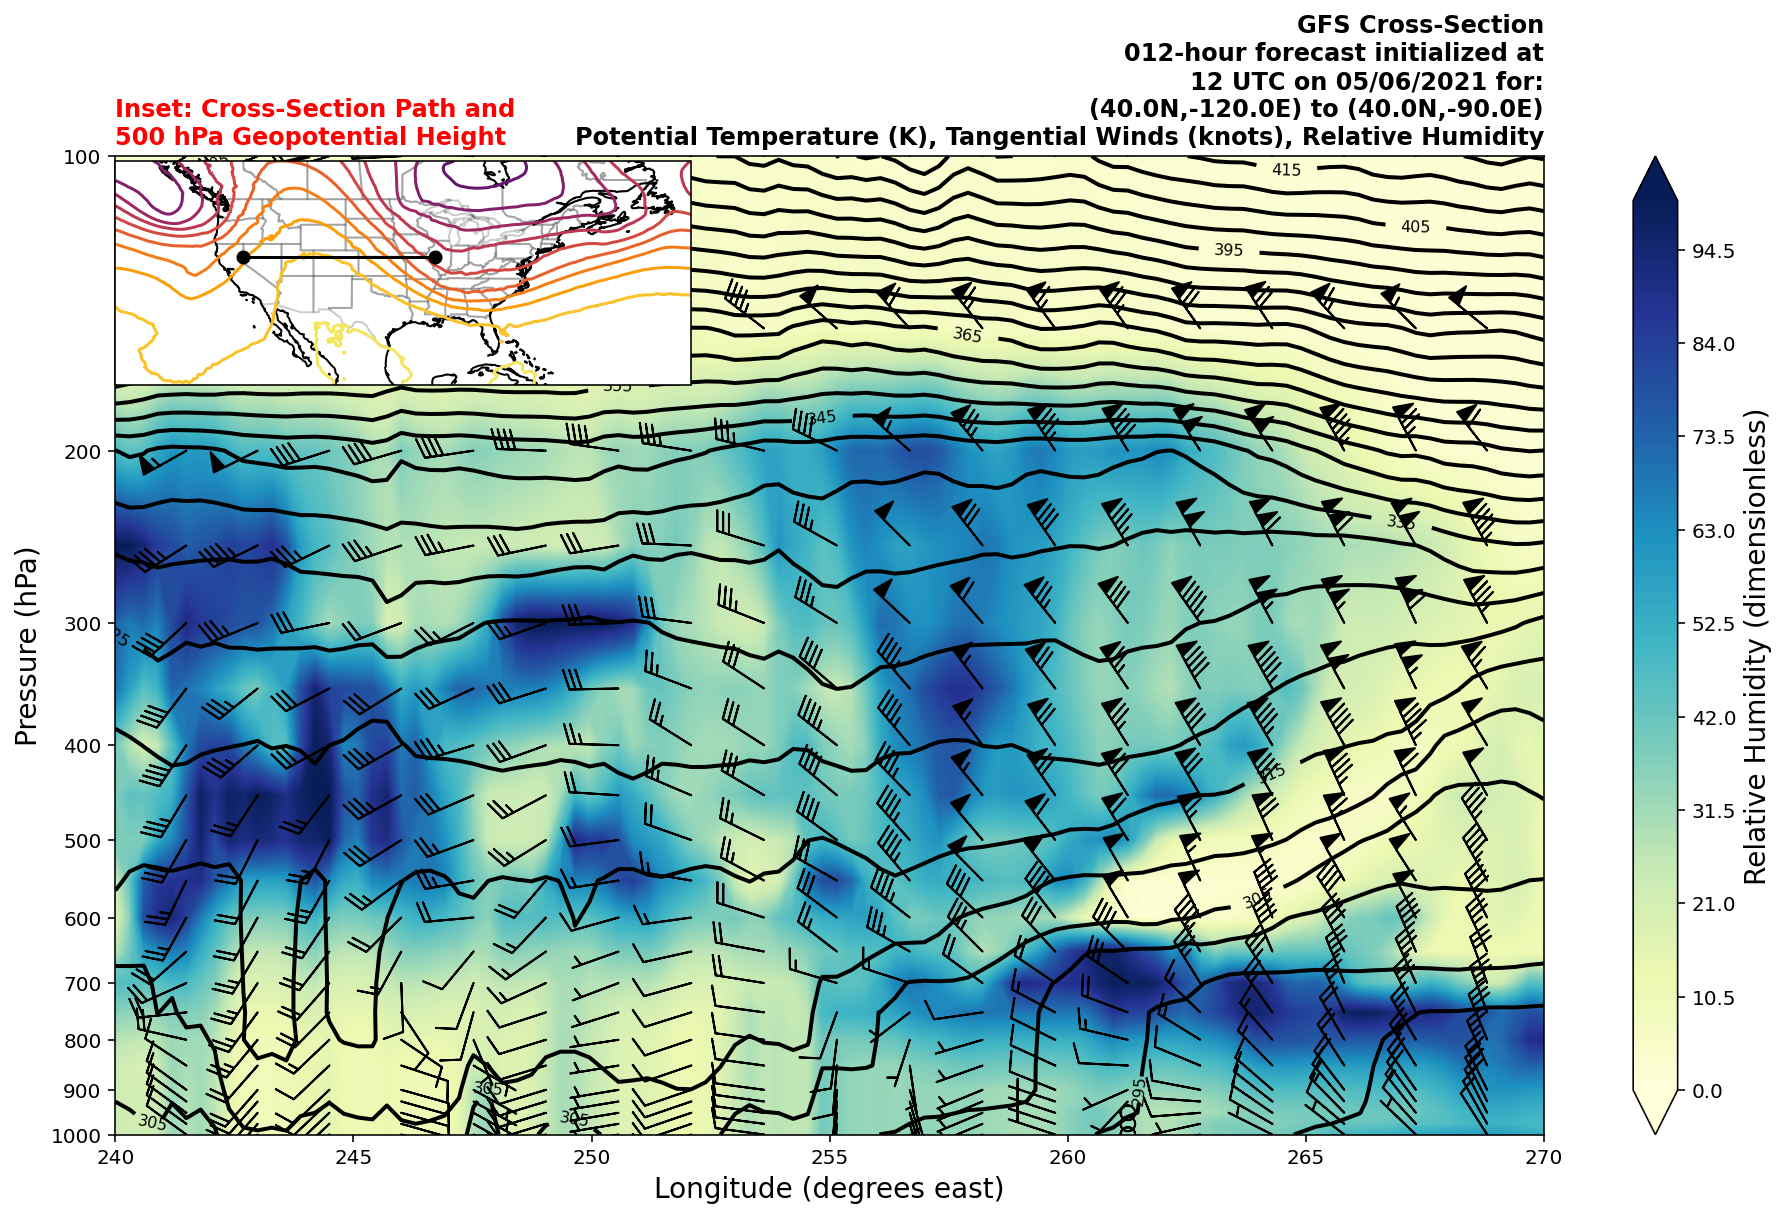

In [22]:
#Make the cross section plot
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['longitude'], press, cross['r'][:-12,:],
                         levels=np.arange(0, 100.5, .5), cmap='YlGnBu',extend="both")
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['longitude'], press, pot_temp,
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
wind_slc_vert = list(range(0, 21, 1))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(cross['longitude'][wind_slc_horz], press[wind_slc_vert],
         cross['t_wind'][wind_slc_vert, wind_slc_horz]*1.94384,
         cross['n_wind'][wind_slc_vert, wind_slc_horz]*1.94384, color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(press.max(), press.min())
ax.set_yticks(np.arange(1000, 50, -100))

# Define the CRS and inset axes
#CONUS
wlon=220
elon=310
slat=20
nlat=55
data_zoom = data.sel(latitude=slice(nlat,slat)).sel(longitude=slice(wlon,elon))

data_crs = data_zoom['gh'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data_zoom['longitude'],
                 data_zoom['latitude'],
                 data_zoom['gh'].sel(isobaricInhPa=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.plot([start[1], end[1]],
            [start[0], end[0]], color="black", marker="o",
            transform=data_crs, zorder=3)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title('GFS Cross-Section\n'+str(model_run)+"-hour forecast initialized at\n"+str(init_hour)+
             ' UTC on '+str(month)+'/'+str(day)+'/'+str(year)+' for:\n'
             '('+str(start[0])+'N,'+str(start[1])+'E) to ('+str(end[0])+'N,'+str(end[1])+'E)' 
             '\nPotential Temperature (K), Tangential Winds (knots), '
             'Relative Humidity',fontweight="bold",loc="right")
ax.set_title('Inset: Cross-Section Path and\n500 hPa Geopotential Height', color='red', fontweight='bold',loc='left')
ax.set_ylabel('Pressure (hPa)',fontsize=14)
ax.set_xlabel('Longitude (degrees east)', fontsize=14)
rh_colorbar.set_label('Relative Humidity (dimensionless)',fontsize=14)

plt.show()